### Split each masked image into `smoky` and `cleany` patches based on percentage of smoky images:

- no smoky pixels: label = `cleany`
- 10% <> 75% pixels: label = `smoky`
- throw away other patches

#### `smoky` and `cleany` patches are saved in separate folders

### Make sure to download images with masks before patchifying
use this script for downloading: `../importing_from_Labelbox/download_masked_smoky_images.ipynb`

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import shutil
from shutil import copy

import numpy as np
import os
from io import BytesIO
from pathlib import Path
from scipy.misc import imsave

Image.MAX_IMAGE_PIXELS = None

In [15]:
input_dir = Path('../data/smoky_images')
dataset_dir = input_dir / 'dataset'

In [25]:
def extract_patches(img_name, patch_size):
    src_img = plt.imread(str(input_dir / img_name))
    patches = []
    
    img_height = src_img.shape[0]
    img_width = src_img.shape[1]

    h_indexes = get_patch_indexes(img_height, patch_size)
    w_indexes = get_patch_indexes(img_width, patch_size)

    for h_i, h in enumerate(h_indexes):    
        for w_i, w in enumerate(w_indexes):
            try:
                patch = src_img[h: h+patch_size, w: w+patch_size, :]
            except IndexError:
                patch = src_img[h: h+patch_size, w: w+patch_size]

            patches.append(patch)
    
    return patches

def get_patch_indexes(img_size, patch_size):
    patches_n = img_size / patch_size
    remainder = img_size % patch_size
    
    # get list of full patches
    indexes = list(range(0, int(patches_n)))
    
    # last patch will start from the end of previous and to the end of the image
    if remainder:
        indexes.append(patches_n - 1)
    
    return [int(i * patch_size) for i in indexes]

In [26]:
problematic_idxs = [38, 89, 93, 103, 153, 168, 258, 271, 353, 428, 433, 469]

In [27]:
shutil.rmtree(dataset_dir, ignore_errors=False, onerror=None)

In [88]:
(dataset_dir / 'smoky').mkdir(parents=True, exist_ok=True)
(dataset_dir / 'cleany').mkdir(parents=True, exist_ok=True)

In [89]:
count = 0
count_smoky = 0
count_cleany = 0

patch_size = 512

full_mask_sum = patch_size * patch_size

min_smoke = 0.005 * full_mask_sum
max_smoke = 0.9 * full_mask_sum

lost_patches = []

for img_name in sorted(os.listdir(input_dir)):
    if 'mask' in str(img_name):
        img_name_parts = img_name.split('.')[0].split('_')
        img_index = img_name_parts[0]
        img_id = img_name_parts[1]
        
        if img_index in problematic_idxs:
            continue
        
        correspondent_image = f'{img_index}_{img_id}_original.png'
        
        mask_patches = extract_patches(img_name, patch_size)
        image_patches = extract_patches(correspondent_image, patch_size)
        
        for patch_index, mask in enumerate(mask_patches):
            mask_sum = np.array(mask).sum()
            
            label = None
            if mask_sum == 0:
                label = 'cleany'
                count_cleany += 1
            elif mask_sum >= min_smoke and mask_sum <= max_smoke:
                label = 'smoky'
                count_smoky += 1
            else:
                lost_patches.append((mask_sum, mask, image_patches[patch_index]))
            
            if label is None:
                continue
            
            dest_path = dataset_dir / label / f'{img_index}_{img_id}_{patch_index}.png'            
            imsave(dest_path, image_patches[patch_index])
        
#         if count == 20:
#             break
        
        if (count + 1) % 500 == 0:
            print(f'{count} imgs processed. smoke: {count_smoky}, clean: {count_cleany}')
        
        count += 1
        
print(f'{count} imgs processed. smoke: {count_smoky}, clean: {count_cleany}')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


499 imgs processed. smoke: 2335, clean: 3230
586 imgs processed. smoke: 2777, clean: 3687


In [86]:
len(lost_patches)

20

### Looking at rejected patches

mask sum: 101.0, masked part: 0.000, i: 0


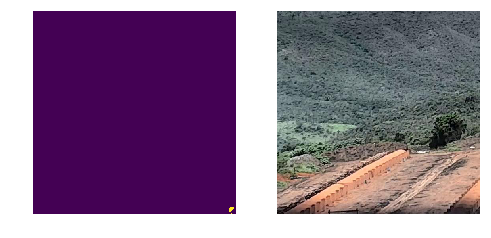

mask sum: 114.0, masked part: 0.000, i: 1


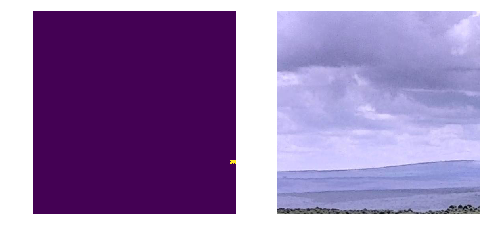

mask sum: 159.0, masked part: 0.001, i: 2


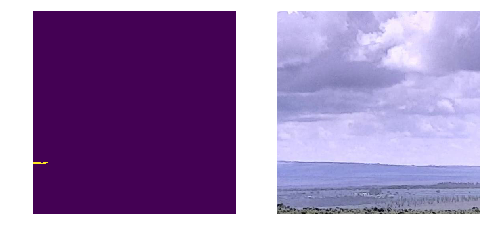

mask sum: 281.0, masked part: 0.001, i: 3


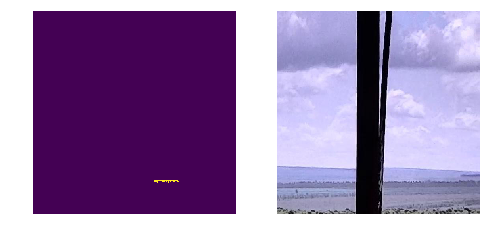

mask sum: 464.0, masked part: 0.002, i: 4


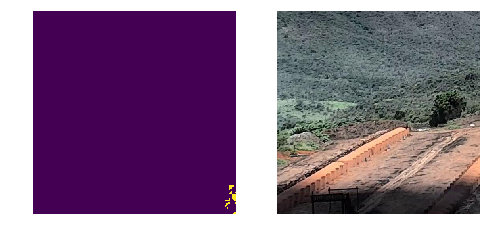

mask sum: 523.0, masked part: 0.002, i: 5


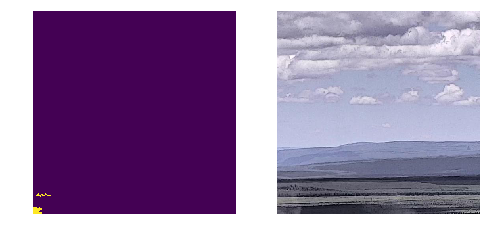

mask sum: 245274.0, masked part: 0.936, i: 6


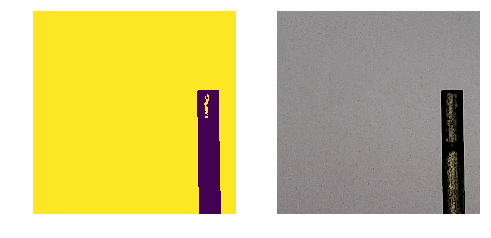

mask sum: 248359.0, masked part: 0.947, i: 7


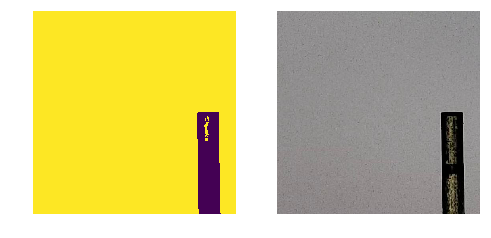

mask sum: 261049.0, masked part: 0.996, i: 8


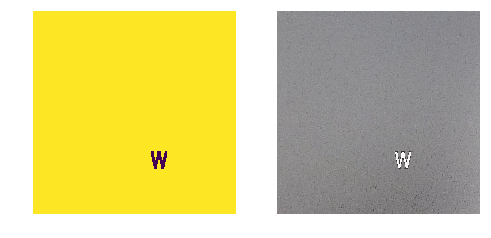

mask sum: 261049.0, masked part: 0.996, i: 9


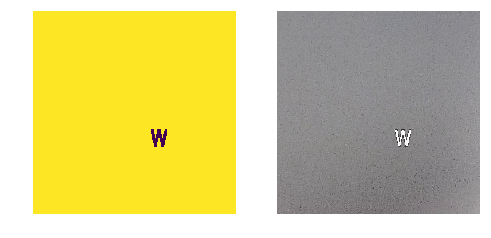

mask sum: 261423.0, masked part: 0.997, i: 10


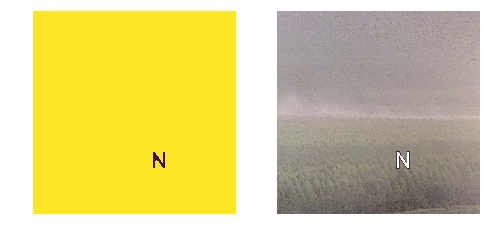

mask sum: 261423.0, masked part: 0.997, i: 11


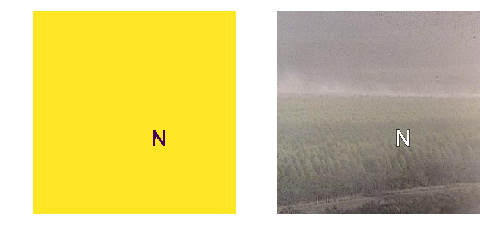

mask sum: 262144.0, masked part: 1.000, i: 12


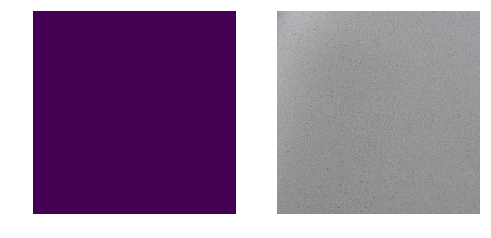

mask sum: 262144.0, masked part: 1.000, i: 13


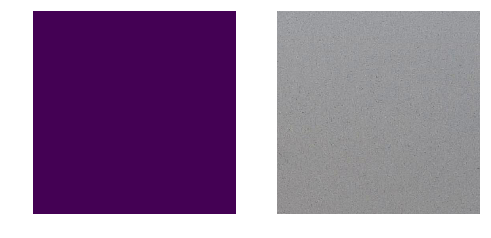

mask sum: 262144.0, masked part: 1.000, i: 14


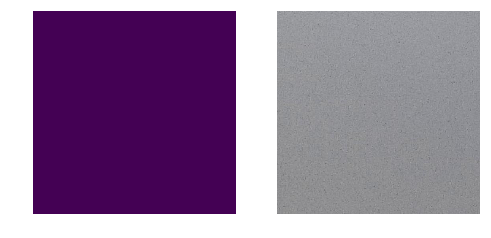

mask sum: 262144.0, masked part: 1.000, i: 15


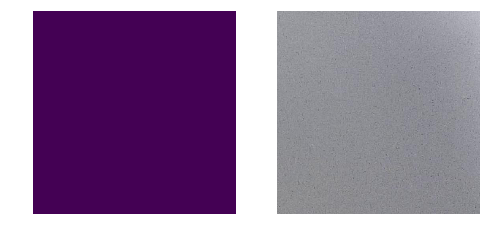

mask sum: 262144.0, masked part: 1.000, i: 16


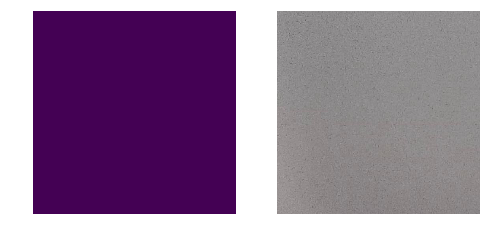

mask sum: 262144.0, masked part: 1.000, i: 17


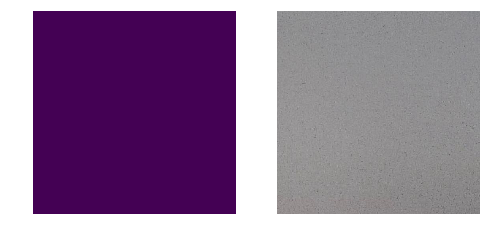

mask sum: 262144.0, masked part: 1.000, i: 18


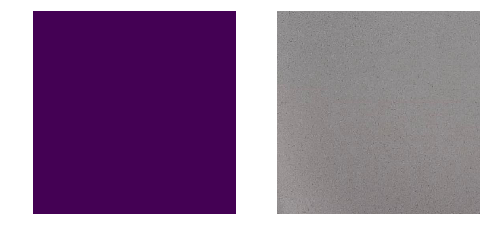

mask sum: 262144.0, masked part: 1.000, i: 19


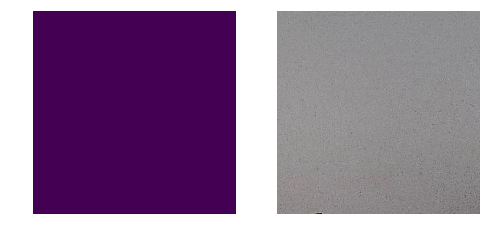

In [87]:
lost_patches.sort(key=lambda x: x[0])

def print_img(axis, img):
    axis.imshow(img)
    axis.axis('off')

for i, (mask_sum, mask, img) in enumerate(lost_patches):
    print(f'mask sum: {mask_sum}, masked part: {(mask_sum / full_mask_sum):.3f}, i: {i}')
    
    # print image and the mask
    f, axarr = plt.subplots(1, 2, figsize=(8, 4))
    print_img(axarr[0], mask)
    print_img(axarr[1], img)
    
    plt.show()